In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq as tdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [65]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')
t = torch.linspace(0., 25., 2000).to(device)
true_A = torch.tensor([[-0.1,2.0], [-2.0, -0.1]]).to(device)
true_y0 = torch.tensor([[2.,0.]]).to(device)
class Lambda(nn.Module):
    def forward(self, t,y):
        return torch.mm(y**3, true_A)

        
with torch.no_grad():
    true_y = tdf.odeint(Lambda(), true_y0, t, method="dopri5")
    

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9900,  0.1986]],

        [[ 1.9795,  0.3942]],

        ...,

        [[-0.4427,  0.2839]],

        [[-0.4432,  0.2816]],

        [[-0.4436,  0.2794]]])
tensor([[[ 2.0000,  0.0000]],

        [[ 1.9900,  0.1986]],

        [[ 1.9795,  0.3942]],

        ...,

        [[-0.4427,  0.2839]],

        [[-0.4432,  0.2816]],

        [[-0.4436,  0.2794]]])


In [66]:
total_size = len(t)
batch_size = 20
batch_num = 10
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(total_size-batch_size, dtype=np.int64), batch_num, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_size]  # ()
    batch_y = torch.stack([true_y[s + i] for i in range(batch_size)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)




In [67]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net(y**3)

In [68]:
def show_traj(t, true_traj, pred_traj):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax1.plot(torch.Tensor([i[0][0] for i in true_traj]), torch.Tensor([i[0][1] for i in true_traj]))
    ax1.plot(torch.Tensor([i[0][0] for i in pred_traj]), torch.Tensor([i[0][1] for i in pred_traj]), linestyle="--")
    ax2.plot(t,torch.Tensor([i[0][0] for i in true_traj]))
    ax2.plot(t,torch.Tensor([i[0][0] for i in pred_traj]), linestyle="--")
    ax3.plot(t,torch.Tensor([i[0][1] for i in true_traj]))
    ax3.plot(t,torch.Tensor([i[0][1] for i in pred_traj]), linestyle="--")
    plt.show()
    

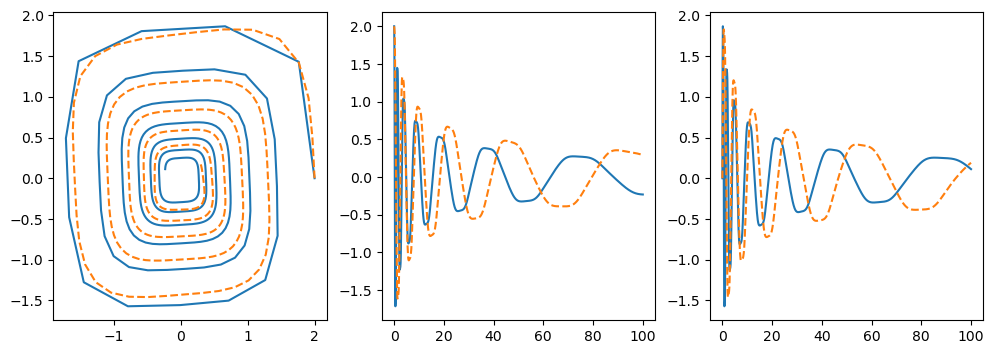

In [73]:
t = torch.linspace(0., 25., 1000).to(device)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

min_loss = 1000
a = []
fig, ax = plt.subplots()
while True:
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = tdf.odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    if loss < min_loss:
        min_loss = loss.item()
        t2 = torch.linspace(0., 100., 1000)
        y_pred = tdf.odeint(func, true_y0, t2)
        y_true = tdf.odeint(Lambda(), true_y0, t2).to(device)
        show_traj(t2, y_true, y_pred)
        clear_output(wait=True)
        
        # ax.plot(torch.Tensor([i[0][0] for i in y_pred.cpu()]),torch.Tensor([i[0][1] for i in y_pred.cpu()]))

        # print("{}\t loss:\t".format("") + str(loss.item()) )
    
    if loss < 1e-3:
        break
    optimizer.step()
    plt.show()

In [71]:
import matplotlib.pyplot as plt

In [26]:
y_pred.cpu()

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9857,  0.4331]],

        [[ 1.9615,  0.8613]],

        ...,

        [[-0.0121,  0.3132]],

        [[-0.0153,  0.3131]],

        [[-0.0186,  0.3131]]], grad_fn=<CopySlices>)

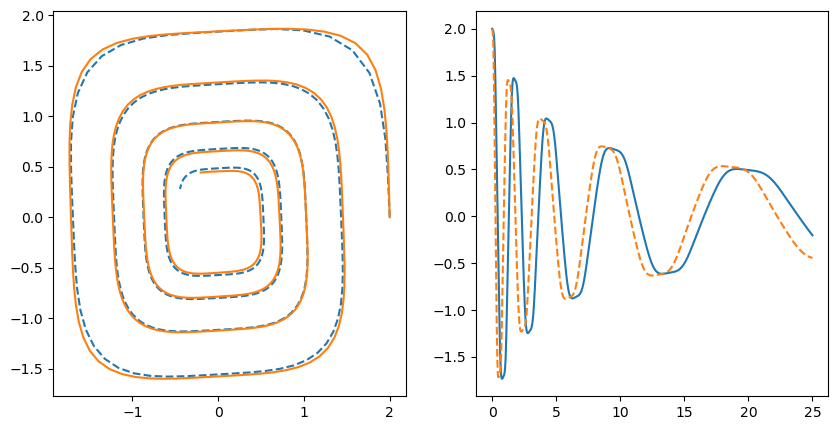

In [27]:

t = torch.linspace(0., 25., 1000).to(device)
y_pred = tdf.odeint(func, true_y0, t).to(device)
y_true = tdf.odeint(Lambda(), true_y0, t).to(device)
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
ax.plot(torch.Tensor([i[0][0] for i in y_true.cpu()]), torch.Tensor([i[0][1] for i in y_true.cpu()]), linestyle='--')
b = ax.plot(torch.Tensor([i[0][0] for i in y_pred.cpu()]), torch.Tensor([i[0][1] for i in y_pred.cpu()]))
ax2 = f.add_subplot(122)
ax2.plot(t.cpu(), torch.Tensor([i[0][0] for i in y_pred.cpu()]))
ax2.plot(t.cpu(), torch.Tensor([i[0][0] for i in y_true.cpu()]), linestyle='--')
# ax2.plot(t.cpu(), torch.Tensor([i[0][1] for i in y_true.cpu()]), linestyle='--')
# ax2.plot(t.cpu(), torch.Tensor([i[0][1] for i in y_pred.cpu()]))
# plt.plot(torch.Tensor([i[0][0] for i in true_y]),  torch.Tensor([i[0][1] for i in true_y]))
# plt.plot()

In [28]:
t.cpu().numpy()

array([ 0.        ,  0.02502503,  0.05005005,  0.07507508,  0.1001001 ,
        0.12512513,  0.15015015,  0.17517518,  0.2002002 ,  0.22522523,
        0.25025025,  0.2752753 ,  0.3003003 ,  0.3253253 ,  0.35035035,
        0.3753754 ,  0.4004004 ,  0.4254254 ,  0.45045045,  0.4754755 ,
        0.5005005 ,  0.5255255 ,  0.5505506 ,  0.5755756 ,  0.6006006 ,
        0.6256256 ,  0.6506506 ,  0.6756757 ,  0.7007007 ,  0.7257257 ,
        0.7507508 ,  0.7757758 ,  0.8008008 ,  0.8258258 ,  0.8508508 ,
        0.8758759 ,  0.9009009 ,  0.9259259 ,  0.950951  ,  0.975976  ,
        1.001001  ,  1.026026  ,  1.051051  ,  1.076076  ,  1.1011012 ,
        1.1261262 ,  1.1511512 ,  1.1761762 ,  1.2012012 ,  1.2262262 ,
        1.2512512 ,  1.2762762 ,  1.3013012 ,  1.3263264 ,  1.3513514 ,
        1.3763764 ,  1.4014014 ,  1.4264264 ,  1.4514514 ,  1.4764764 ,
        1.5015016 ,  1.5265266 ,  1.5515516 ,  1.5765766 ,  1.6016016 ,
        1.6266266 ,  1.6516516 ,  1.6766766 ,  1.7017016 ,  1.72

In [29]:
all[0][0][1]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
len(all)

1000